In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
insta_com = pd.read_csv('C:\\Users\\Artem\\Desktop\\Coding\\Datasets\\Instagram_comments\\instagram comments 7M.csv', sep = ',')

In [3]:
insta_com.shape


(7286287, 6)

In [4]:
insta_com['text'].head(40)

0                                                 Супер
1                                                 Класс
2     @wanjaivann 🤣 я в Питере, фотку просто только ...
3     @eleonorashmid666 oh very goood ✈️ Я отправил ...
4           @eleonorashmid666 Я отправил тебе сообщение
5                                           Песдато🔥🔥🔥🔥
6                                     яндекс а ты норм😍
7                              @048racer 048 ты мелкий🙊
8                              @_yanndexx_ не сказал бы
9                                            Красивая 💗
10                            Четкая обработка зрачков👌
11                          @ras_al_ghul47 это софтбокс
12            @ras_al_ghul47 его даже в отражении видно
13             @sonya_koshkina1720 я не шарю все равно)
14                                    Красивая такая😻😻😻
15                          @alinkayashchenko спасибо 💓
16                          @eleonorashmid666 вы женаты
17           @eleonorashmid666 Приедешь снова в 

In [7]:
data = pd.read_csv('C:\\Users\\Artem\\Desktop\\Coding\\Datasets\\Instagram_comments\\labeled.csv', sep = ',')

In [8]:
data.head(15)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [9]:
data.value_counts('toxic')

toxic
0.0    9586
1.0    4826
dtype: int64

In [10]:
for true_value in data[data['toxic'] == 1]['comment'].head():
    print(true_value)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [11]:
train_data, test_data = train_test_split(data, test_size = 500, random_state = 0)
test_data.shape

(500, 2)

In [12]:
test_data['toxic'].value_counts()

0.0    346
1.0    154
Name: toxic, dtype: int64

In [13]:
train_data['toxic'].value_counts()

0.0    9240
1.0    4672
Name: toxic, dtype: int64

In [14]:
sentence_example = data.loc[0, 'comment'] # 'Верблюдов-то за что? Дебилы, бл...\n'

tokens = word_tokenize(sentence_example, language = 'russian') # ['Верблюдов-то', 'за', 'что', '?', 'Дебилы', ',', 'бл', '...']
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation] # ['Верблюдов-то', 'за', 'что', 'Дебилы', 'бл', '...']

russian_stop_words = stopwords.words('russian') # ['и', 'в', 'во', 'не', ...]
tokens_without_russian_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words] # ['Верблюдов-то', 'Дебилы', 'бл', '...']

snowball = SnowballStemmer(language = 'russian')
stemmed_tokens = [snowball.stem(i) for i in tokens_without_russian_stop_words_and_punctuation] # ['верблюдов-т', 'дебил', 'бл', '...']

print(f"Исходный текст: {sentence_example}")
print(f"Обработанный текст: {stemmed_tokens}")

Исходный текст: Верблюдов-то за что? Дебилы, бл...

Обработанный текст: ['верблюдов-т', 'дебил', 'бл', '...']


In [15]:
russian_stop_words = stopwords.words('russian')
snowball = SnowballStemmer(language = 'russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

tokenize_sentence(sentence_example)

['верблюдов-т', 'дебил', 'бл', '...']

In [16]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True))
features = vectorizer.fit_transform(train_data['comment'])

In [17]:
model = LogisticRegression(random_state = 0)
model.fit(features, train_data['toxic']) # Implementation of the model using logistic regression

LogisticRegression(random_state=0)

In [18]:
model.predict(features[0])

array([0.])

In [19]:
train_data['comment'].iloc[0]

'Кровопускание уже вернулось:\n'

In [20]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ('model', LogisticRegression(random_state = 0))
])

model_pipeline.fit(train_data['comment'], train_data['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000002296E17A050>)),
                ('model', LogisticRegression(random_state=0))])

In [26]:
model_pipeline.predict(["Какой хороший сын вырос у твоих отцов"])

array([1.])

In [27]:
print(f"Precision: {precision_score(test_data['toxic'], model_pipeline.predict(test_data['comment']))}")
print(f"Recall: {recall_score(test_data['toxic'], model_pipeline.predict(test_data['comment']))}")

Precision: 0.9196428571428571
Recall: 0.6688311688311688


C:\Users\Artem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


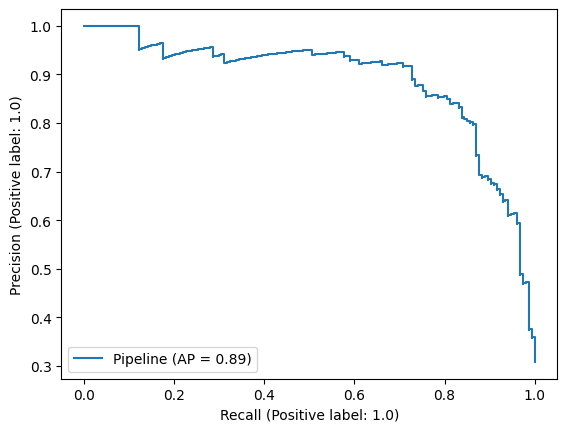

In [30]:
plot_precision_recall_curve(estimator = model_pipeline, X = test_data['comment'], y = test_data['toxic'])

In [31]:
prec, rec, thresholds = precision_recall_curve(test_data['toxic'], model_pipeline.predict_proba(test_data['comment'])[:, 1])
np.where(prec > 0.95)

(array([417, 418, 453, 454, 455, 456, 457, 458, 471, 472, 473, 474, 475,
        476, 477, 478, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
        490, 491, 492, 493, 494, 495, 496, 497, 498], dtype=int64),)

In [32]:
print(f"Precision: {precision_score(test_data['toxic'], model_pipeline.predict_proba(test_data['comment'])[:, 1] > thresholds[345])}")
print(f"Recall: {recall_score(test_data['toxic'], model_pipeline.predict_proba(test_data['comment'])[:, 1] > thresholds[345])}")

Precision: 0.8366013071895425
Recall: 0.8311688311688312


In [33]:
param_grid = {'C': [0.1, 1, 10.]}

grid_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ('model',  GridSearchCV(LogisticRegression(random_state = 0, max_iter=200), param_grid, cv=3, verbose=4))
])

grid_pipeline.fit(train_data['comment'], train_data['toxic'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.686 total time=   0.1s
[CV 2/3] END .............................C=0.1;, score=0.687 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.685 total time=   0.1s
[CV 1/3] END ...............................C=1;, score=0.829 total time=   0.2s
[CV 2/3] END ...............................C=1;, score=0.842 total time=   0.2s
[CV 3/3] END ...............................C=1;, score=0.837 total time=   0.2s
[CV 1/3] END ............................C=10.0;, score=0.854 total time=   0.5s
[CV 2/3] END ............................C=10.0;, score=0.865 total time=   0.5s
[CV 3/3] END ............................C=10.0;, score=0.872 total time=   0.6s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000022913BBC550>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(max_iter=200,
                                                           random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [34]:
model_pipeline_c_10 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ('model', LogisticRegression(random_state = 0, C=10, max_iter=200))
])

model_pipeline_c_10.fit(train_data['comment'], train_data['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000022913BBC9D0>)),
                ('model',
                 LogisticRegression(C=10, max_iter=200, random_state=0))])

In [35]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(test_data['toxic'], model_pipeline_c_10.predict_proba(test_data['comment'])[:, 1])

In [36]:
np.where(prec_c_10 > 0.95)

(array([400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
        413, 414, 415, 416, 417, 418, 426, 427, 428, 429, 430, 431, 432,
        433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
        446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458,
        459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471,
        472, 473, 474, 475, 476, 477, 478, 487, 488, 489, 490, 491, 492,
        493, 494, 495, 496, 497, 498], dtype=int64),)

In [37]:
print(f"Precision: {precision_score(test_data['toxic'], model_pipeline_c_10.predict_proba(test_data['comment'])[:, 1] > thresholds_c_10[271])}")
print(f"Recall: {recall_score(test_data['toxic'], model_pipeline_c_10.predict_proba(test_data['comment'])[:, 1] > thresholds_c_10[271])}")

Precision: 0.6228070175438597
Recall: 0.922077922077922
